#  Redes Neuronales Recurrentes (RNN) - MODELOS LSTM Y GRU

### Unidad de Memoria Larga a Corto Plazo (LSTM - Long short-term memory)   

Cada unidad está compuesta por cinco neuronas: una célula de actualización (update cell), una célula de memoria (memory cell), y las tres puertas de control (control gates) de esta última. Las tareas de cada una de ellas son las siguientes:

 – **célula de memoria ($c_t$)**: Se encarga de custodiar y almacenar información a lo largo del tiempo.

 – **célula de actualización ($u_t$)**: Se encarga de recibir información nueva procedente de la capa anterior.

 – **puerta de entrada ($i_t$)**: Determina cuánta cantidad información procedente de la célula de actualización ($u_t$) se incorpora a la célula de memoria ($c_t$). Junto con la célula de actualización, determinan lo que se procede a incorporar en la memoria.

 – **puerta de salida ($o_t$)**: indica cuánta información de la célula de memoria es transmitida a la capa siguiente. El estado de la unidad al completo **h(t)** se determina haciendo multiplicar el valor de la puerta de salida por el de la célula de memoria (**ct**). Dicho estado total se transmite a las neuronas de la capa posterior.

 – **puerta de olvido ($f_t$)**: Determina cuánta información debe olvidar la célula de memoria en el instante **t**.   


<img src="./img/LSTM_2.jpg" width=750 height=500>   

Los símbolos de suma y producto representan operaciones aritméticas. El estado previo $h_{t-1}$ y el input $d_t$ son vectores que se concatenan (operación representada como un punto). Este vector de entrada será el argumento de las tres puertas y la célula de actualización de la LSTM. En pocas palabras, las puertas tienen la función de modificar el peso que otorga a cada uno de los valores puesto que siendo funciones logísticas, su valor varía de **0** a **1**.

La función de activación de las células de actualización y memoria es la **tangente hiperbólica (tanh)**. La función de las tres puertas de control es la función **sigmoide (σ)**.

Las tres puertas de control reciben como entrada los valores de la capa anterior ($d_t$) así como el estado total de la unidad en el instante inmediatamente anterior ($h_{t-1}$).    


Existe, como se observa, una especie de bucle de retroalimentación, en función del que los valores de salida de la unidad al completo alimentan a cada una de las tres puertas de control.

### Unidad Recurrente con Puerta (GRU - Gated Recurrent Unit)   

La **unidad recurrente con puerta (GRU)** es una variación de la **LSTM**. Ambas tienen similitudes de diseño y, en algunos casos, producen resultados parecidos.    
La GRU utiliza una compuerta de actualización y una compuerta de reinicio para resolver el problema de desvanecimiento de gradiente. Estas compuertas deciden qué información es importante y la pasan a la salida.    
Las compuertas pueden entrenarse para almacenar información de hace mucho tiempo, sin que se desvanezca con el tiempo y sin eliminar la información irrelevante.  

Esta unidad de compone cuatro células: una de ellas es la célula de estado candidato (candidate state cell, $u_t$, similar a la célula de actualización de las LSTMs), y las otras dos son puertas de control (entrada, $z_t$, y olvido, $r_t$) de la primera. La principal diferencia con las LSTMs es que las GRUs carecen de puerta de salida.

La activación de este tipo de unidades requiere de menores recursos computacionales que las LSTM. A pesar de ello, se ha encontrado que el rendimiento de las GRUs es similar o superior en caso de bases de datos pequeñas.

<img src="./img/gru.webp" width=700>   

En la imagen superior de una unidad GRU, se visualizan los siguientes elementos:    
- La puerta de estado candidato **c** es la principal (área naranja). 
- Cuánto influye la respuesta del estado previo en ella se encuentra determinado por la puerta **r** (área amarilla). 
- Cuánto influye ese estado previo en su respuesta está bajo el control de la puerta **z** (área roja).

A diferencia de la LSTM, la GRU no tiene estado de celda **Ct**. Solo tiene un estado oculto **ht**, y debido a la sencillez de su arquitectura, la GRU tiene un tiempo de entrenamiento menor que los modelos LSTM. La arquitectura GRU es fácil de entender, ya que toma la entrada **xt** y el estado oculto de la marca temporal anterior **ht-1** y da como salida el nuevo estado oculto **ht**. 



## PREDICCIÓN PRECIO ACCIONES CON MODELOS LSTM Y GRU

In [1]:
# Importando as librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(455)
np.random.seed(455)


2025-03-19 17:33:28.496894: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-19 17:33:29.013882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742405609.260932    3365 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742405609.339862    3365 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-19 17:33:29.956974: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Análisis de datos   

Se carga el dataset de MasterCard añadiendo la columna Date al índice y convirtiéndola al formato DateTime.    
Se eliminan las columnas irrelevantes del dataset, para utilizar únicamente los precios de las acciones, el volumen y la fecha.   
El  dataset tiene Date como índice y Open, High, Low, Close y Volume como columnas.

In [ ]:

# Carga del dataset Mastercard, eliminando las columnas Dividends y Stock Splits y parseando la columna Date
dataset = pd.read_csv(
    "datasets/Mastercard_stock_history.csv", index_col="Date", parse_dates=["Date"] # el parametro parse_dates convierte la columna Date en un objeto de tipo datetime
).drop(["Dividends", "Stock Splits"], axis=1)

print(dataset.head())


                Open      High       Low     Close     Volume
Date                                                         
2006-05-25  3.748967  4.283869  3.739664  4.279217  395343000
2006-05-26  4.307126  4.348058  4.103398  4.179680  103044000
2006-05-30  4.183400  4.184330  3.986184  4.093164   49898000
2006-05-31  4.125723  4.219679  4.125723  4.180608   30002000
2006-06-01  4.179678  4.474572  4.176887  4.419686   62344000


Se analizan los datos usando `describe()`. Nos fijamos en la columna **High**, pues se va a usar para entrenar el modelo.    
También es posible elegir las columnas Close u Open para una característica del modelo, pero High tiene más sentido, ya que proporciona información de lo alto que subieron los valores de la acción en un día determinado.

El precio mínimo de las acciones es de 4,10 dólares y el máximo es de 400,5 dólares.    
La media está en 105,9 dólares y la desviación típica, en 107,3 dólares, lo que significa que las acciones tienen una varianza elevada.

In [3]:
print(dataset.describe())

              Open         High          Low        Close        Volume
count  3872.000000  3872.000000  3872.000000  3872.000000  3.872000e+03
mean    104.896814   105.956054   103.769349   104.882714  1.232250e+07
std     106.245511   107.303589   105.050064   106.168693  1.759665e+07
min       3.748967     4.102467     3.739664     4.083861  6.411000e+05
25%      22.347203    22.637997    22.034458    22.300391  3.529475e+06
50%      70.810079    71.375896    70.224002    70.856083  5.891750e+06
75%     147.688448   148.645373   146.822013   147.688438  1.319775e+07
max     392.653890   400.521479   389.747812   394.685730  3.953430e+08


Seguidamente, se intenta comprobar si existen valores faltantes, usando `.isna().sum()`.

In [4]:
dataset.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

La función `train_test_plot` dispone de tres argumentos: *dataset*, *tstart* y *tend*. Esta función traza un gráfico de líneas sencillo, dónde `tstart` y `tend` son límites de tiempo en años.    
Es posible cambiar estos argumentos para analizar periodos concretos.    

El gráfico de líneas se divide en dos partes: entrenamiento y prueba. Esto permitirá decidir la distribución del conjunto de datos de prueba.

El precio de las acciones de MasterCard lleva subiendo desde 2016. Tuvo un bajón en el primer trimestre de 2020, pero se estabilizó en la segunda mitad del año. Nuestro conjunto de datos de prueba consta de un año, de 2021 a 2022, y el resto del conjunto de datos se utiliza para el entrenamiento.

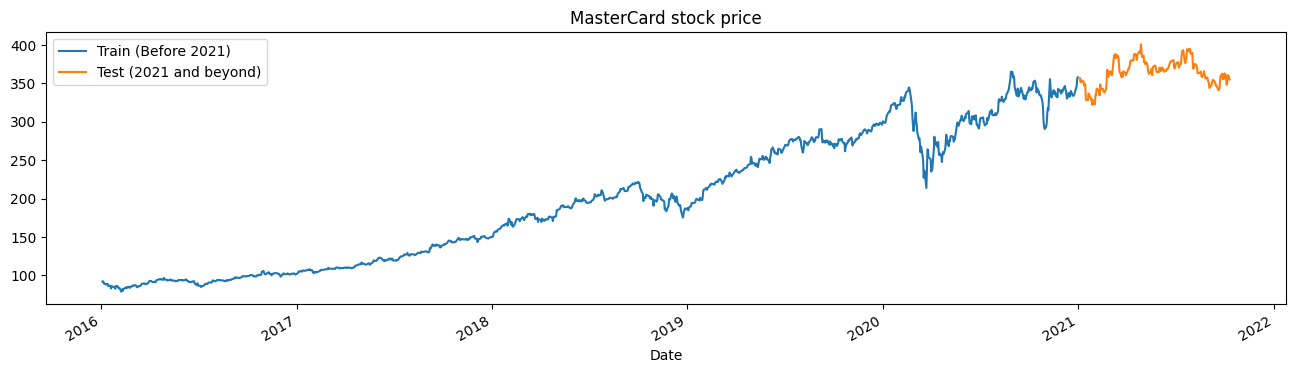

In [5]:
tstart = 2016
tend = 2020

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("MasterCard stock price")
    plt.show()

train_test_plot(dataset,tstart,tend)

## Preprocesado de datos   

Una vez separado el dataset en los conjuntos de train y test, se usa la función MinMaxScaler para estandarizar el conjunto de entrenamiento, lo que ayudará a evitar los valores atípicos, anomalías o outliers. También se puede probar a utilizar StandardScaler o cualquier otra función escalar para normalizar los datos y mejorar el rendimiento del modelo.

In [6]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"].values
    test = dataset.loc[f"{tend+1}":, "High"].values
    return train, test

training_set, test_set = train_test_split(dataset, tstart, tend)

In [ ]:
#  Normalización de los datos, usando MinMaxScaler para escalar los datos entre 0 y 1
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

La función `split_sequence` utiliza un conjunto de datos de entrenamiento y lo convierte en entradas (X_train) y salidas (y_train).

Por ejemplo, si la secuencia es [1,2,3,4,5,6,7,8,9,10,11,12] y el n_step es tres, convertirá la secuencia en tres marcas de tiempo de entrada y una salida, como se muestra a continuación:   

| X | y |
|---|---|
|1,2,3|	4|
|2,3,4|	5|
|3,4,5|	6|
|4,5,6|	7|
|…|	…|   

En este caso, se usan 60 n_steps. También se puede reducir o aumentar el número de pasos para optimizar el rendimiento del modelo.

In [ ]:
# Función para dividir la serie temporal en muestras
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # encontrar el final de este patrón
        end_ix = i + n_steps
        # comprobar si estamos más allá de la secuencia
        if end_ix > len(sequence) - 1:
            break
        # Obtener las partes de entrada y salida del patrón
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60
features = 1

# Dividir la serie temporal en muestras
X_train, y_train = split_sequence(training_set_scaled, n_steps)

Se trabaja con series univariadas, por lo que el número de características es uno, y es necesario remodelar/reescalar el conjunto *X_train* para que se ajuste al modelo LSTM.    
*X_train* tiene **[samples, timesteps]**, y lo remodelaremos a **[samples, timesteps, features]**.

In [ ]:
# Reescalar X_train para un modelado eficiente
# El reescalado se hace para que la red neuronal pueda entender los datos
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features) 

## Modelo usando LSTM

El modelo consta de una capa oculta única de LSTM y una capa de salida.    

Se puede experimentar con el número de unidades, ya que con más unidades se puede obtener mejores resultados. Para este caso, se fijan las unidades LSTM en 125, *tanh* como activación y también se fija el tamaño de entrada.

***Nota***: La librería Tensorflow permite usar simplemente los módulos LSTM o GRU para construir el modelo, sin necesidad de construir toda la arquitectura.

Para compilar el modelo se usa un optimizador **RMSprop** y el **error cuadrático medio (MSE)** como función de pérdida.

In [ ]:
#  Creación del modelo LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features))) # 125 neuronas en la capa oculta dado que el dataset es pequeño
model_lstm.add(Dense(units=1))

# Complicación del modelo
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

2025-03-19 17:42:00.909803: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 125)            │        63,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,626 (248.54 KB)

 Trainable params: 63,626 (248.54 KB)

 Non-trainable params: 0 (0.00 B)

El modelo se entrenará en 50 epochs con un batch_size igual a 32.    

Se pueden cambiar los hiperparámetros para reducir el tiempo de entrenamiento o mejorar los resultados.

In [ ]:
# Entrenamiento del modelo
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.0520
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.0052
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.0018
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.0018
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.0011
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.0011
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 8.3928e-04
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 7.5517e-04
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 9.4611e-04
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 8.5456e-04
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 7.9185e-04
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 7.4363e-04
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 7.0242e-04
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 6.6399e-04
Epoch 15/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 

## Resultados   

Se vuelve a repetir el preprocesamiento y a normalizar el conjunto de test.    

En primer lugar, se transforma el conjunto de datos y, a continuación, se divide en muestras, dándole una nueva forma, se realiza la predicción y se aplica el método de la transformada inversa a las predicciones para darles forma estándar y obtener el valor real de las acciones.

In [ ]:
# Preparación del conjunto de test, haciendo un reshape de los datos
dataset_total = dataset.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs) # Normalización de los datos, usando MinMaxScaler, definido anteriormente, para escalar los datos entre 0 y 1

In [ ]:
# Dividir la serie temporal de X_test en muestras
X_test, y_test = split_sequence(inputs, n_steps)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features) # Reescalar X_test.
predicted_stock_price = model_lstm.predict(X_test)                  # Predicción del precio de las acciones
predicted_stock_price = sc.inverse_transform(predicted_stock_price) # Desnormalización de los datos para obtener el precio real de las acciones


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


La función `plot_predictions` genera un gráfico de líneas de valores reales frente a valores previstos. Esto permite visualizar la diferencia entre los valores reales y los previstos.

La función `return_rmse` toma argumentos de prueba y predicción e imprime el parámetro de raíz del error cuadrático medio (RMSE).

In [25]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicción")
    plt.title("Predicción del precio de las acciones de MasterCard")
    plt.xlabel("Tiempo")
    plt.ylabel("Precio de la acción")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("El valor de RMSE es {:.2f}.".format(rmse))


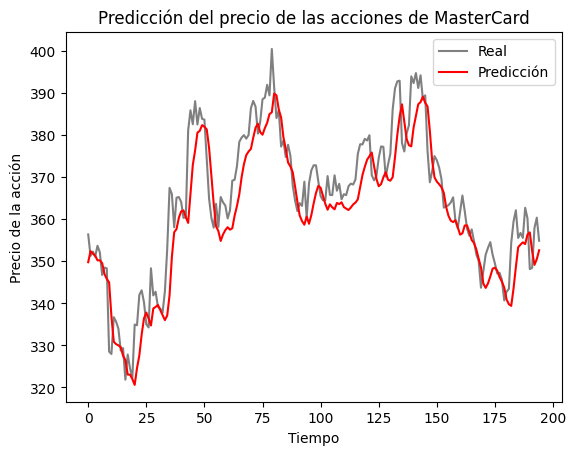

In [28]:
# Visualización de las predicciones para la red LSTM
plot_predictions(test_set,predicted_stock_price)

Según el gráfico de líneas anterior, se puede decir que el modelo LSTM de capa única ha funcionado relativamente bien.

In [29]:
# Evaluación del modelo LSTM
return_rmse(test_set,predicted_stock_price)

El valor de RMSE es 7.36.


## Modelo usando GRU

Se va a mantener la misma estructura, cambiando únicamente la capa LSTM por la capa GRU para comparar adecuadamente los resultados.    
Por tanto, la nueva estructura del modelo contiene una capa GRU única con 125 unidades y una capa de salida.

In [ ]:
#  Creación del modelo GRU
model_gru = Sequential()

# Primera capa GRU con regularización de Dropout
model_gru.add(GRU(units=125, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))

# Compilación del modelo
model_gru.compile(optimizer="RMSprop", loss="mse")

model_gru.summary()


/usr/local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 125)            │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,126 (187.99 KB)

 Trainable params: 48,126 (187.99 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#  Entrenamiento del modelo
model_gru.fit(X_train, y_train, epochs=50, batch_size=32)


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0474
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 0.0024
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 0.0011
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 9.5901e-04
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 8.9987e-04
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 9.8204e-04
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 7.5390e-04
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 8.4477e-04
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 7.6556e-04
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 7.5221e-04
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 7.0877e-04
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 6.7712e-04
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 6.4575e-04
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 6.1198e-04
Epoch 15/50
38/38 ━━━━━━━

## Resultados   

El gráfico de líneas con los valores previstos, en esta ocasión casi se ajusta a los valores reales.


In [19]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


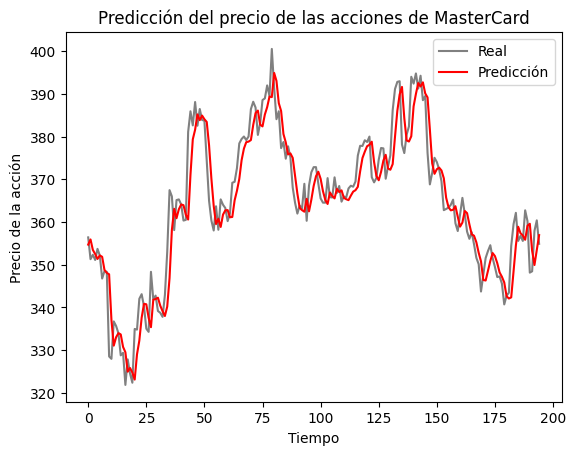

In [30]:
# Visualización de las predicciones para la red GRU
plot_predictions(test_set, GRU_predicted_stock_price)


In [31]:
# Evaluación del modelo GRU 
return_rmse(test_set,GRU_predicted_stock_price)

El valor de RMSE es 5.90.


El modelo GRU devuelve un valor de RMSE ligeramente inferior en el conjunto de datos de prueba, lo que supone una mejora respecto al modelo LSTM.